<a href="https://colab.research.google.com/github/zxzhaixiang/MachineLearning_demo/blob/master/node2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install hiddenlayer

In [0]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

import hiddenlayer as hl


In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device is {device}')

device is cuda


In [0]:
def get_random_AdjMat(n, prob = 0.5):
    a = np.random.rand(n,n)
    a = (a+a.T)*0.5
    x = np.sqrt(prob/2.0) if prob<0.5 else 1-np.sqrt((1.0-prob)/2.0)
    A = np.asarray(a<x, dtype=np.int)
    for i in range(n):
        A[i][i] = 1
    return A

In [0]:
n = 100
Adj = get_random_AdjMat(n,0.1)


In [0]:
G = nx.from_numpy_matrix(Adj)

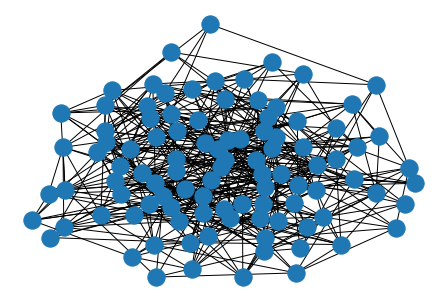

In [0]:
nx.draw(G)

## Prepare dataset

In [0]:
batch_size = 64

In [0]:
I = np.repeat(np.arange(n).reshape((1,-1)),n,axis=0)
J = I.T

In [0]:
I = torch.LongTensor(I.flatten()).reshape(-1,1)
J = torch.LongTensor(J.flatten()).reshape(-1,1)
A = torch.FloatTensor(Adj.flatten()).reshape(-1,1)

In [0]:
train_dataset = torch.utils.data.TensorDataset(I,J,A)

In [0]:
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

In [0]:
nBatch_train = train_loader.__len__()

## Build model

In [0]:
class Node2Vec(nn.Module):
    def __init__(self, nNode, em_dim = 8):
        super(Node2Vec, self).__init__()
        self.node_em = nn.Embedding(nNode, em_dim, max_norm = 1, scale_grad_by_freq=False)
        self.cos_sim = nn.CosineSimilarity(dim=2, eps=1e-6)
    def forward(self, n1_id, n2_id):
        n1_em = self.node_em(n1_id)
        n2_em = self.node_em(n2_id)
        return self.cos_sim(n1_em, n2_em)        

In [0]:
n2v = Node2Vec(n, em_dim=8).to(device)

In [0]:
n2v(torch.LongTensor(np.zeros((2,1))).to(device),torch.LongTensor(np.zeros((2,1))).to(device))

tensor([[1.],
        [1.]], device='cuda:0', grad_fn=<DivBackward0>)

## Train

In [0]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(n2v.parameters(), lr = 0.001, betas = (0.5, 0.999))
#optimizer = torch.optim.SGD(n2v.parameters(), lr = 0.01)

In [0]:
epoch_num = 100

In [0]:
for e in range(epoch_num):
    train_loss = 0
    for n1,n2,a in train_loader:
        n1,n2,a = n1.to(device), n2.to(device), a.to(device)
        a_pred = n2v(n1,n2)
        l = criterion(a_pred, a)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()

        train_loss += l.item()/nBatch_train
    
    print(f'epoch {e}, loss={train_loss}')



epoch 0, loss=0.2212193072032017
epoch 1, loss=0.21527348885870295
epoch 2, loss=0.21004184027006675
epoch 3, loss=0.2058415738925054
epoch 4, loss=0.20159748595231655
epoch 5, loss=0.19736756204040182
epoch 6, loss=0.19489057722744668
epoch 7, loss=0.19019762635420834
epoch 8, loss=0.18604887908051732
epoch 9, loss=0.18283552410686096
epoch 10, loss=0.17831248861209598
epoch 11, loss=0.17464974655467239
epoch 12, loss=0.17162192451536276
epoch 13, loss=0.16740921851556015
epoch 14, loss=0.16387344986959618
epoch 15, loss=0.16071187562433775
epoch 16, loss=0.15741930038306354
epoch 17, loss=0.1543728217577479
epoch 18, loss=0.15132618315850094
epoch 19, loss=0.14891993876095785
epoch 20, loss=0.14605432611172364
epoch 21, loss=0.14354661168756006
epoch 22, loss=0.14229888279157082
epoch 23, loss=0.13908828657334016
epoch 24, loss=0.13753117530778713
epoch 25, loss=0.13601087911683285
epoch 26, loss=0.13416187640777816
epoch 27, loss=0.13252136011602014
epoch 28, loss=0.1310239689555137

In [0]:
em = n2v.node_em.weight.data.detach().cpu().numpy()

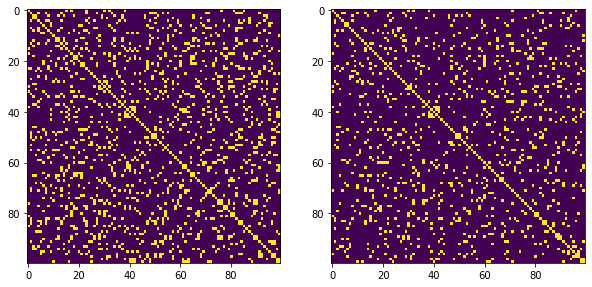

In [0]:
plt.figure(figsize=(10,20))
plt.subplot(121)
plt.imshow(em.dot(em.T)>0.5)
plt.subplot(122)
plt.imshow(Adj)